In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
import time
#from progress.bar import Bar

sns.set()
sns.set_style("white")

%matplotlib inline


## Simulation module implementation

### Description of the simulation module

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v - sI_F)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + sI_F)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 50$, for a duration of one time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $y$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $y$.
    
    
In particular, $ \tau\frac{dI}{dt} = sK(y-y_0)  $

In [2]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5,
              'first_duration': 750}

In [3]:
def thresh_exp(x):
    '''Sigmoid non-linearity'''
    return 1 / (1 + np.exp(-x))

def start_simulation_parallel(state_init, params, K, sigma, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wuv']
    Wvt = params['Wvt']
    Wvu = params['Wvu']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # Update I, u, v and y
        I += (sig * K * (y - y0)) / tau * dt
        u += (-u + thresh_exp(Wut * I - Wuv * v - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        v += (-v + thresh_exp(Wvt * I - Wvu * u + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        y += (-y + u - v + np.random.randn(ntrials) * sigma) / tau * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [4]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(PARAMS_DICT['y0'], 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [5]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst):
    '''
    Input:
    - ylst: np array of y activations
    
    Output:
    A 1d array of the times to threshold of the last behavior
    '''
    ndiscard = 10
    threshold = PARAMS_DICT['y0']
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials, duration, nstages, sigma, K, initI):
    # Initial run
    first_duration = PARAMS_DICT['first_duration'] #duration in ms of first duration (500 ms + exponential with mean 250)
    
    nbin = int(duration / PARAMS_DICT['dt'])
    nbinfirst = int(first_duration / PARAMS_DICT['dt'])
    
    uinit = PARAMS_DICT['uinit']
    vinit = PARAMS_DICT['vinit']
    yinit = PARAMS_DICT['yinit']

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * uinit, 
                  np.ones(ntrials) * vinit,
                  np.ones(ntrials) * yinit,
                  0.0]

    ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, nbinfirst)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin)
        else:
            if k == 0:
                # No update for first flash
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, 1)
            else:
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin * 2)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        print(len(siglst))
        siglst[-1] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2


def get_time_lst(ntrials, duration, nstages, sigma, K, initI):
    '''Simulate and return the array of times of threshold crossing'''
    _, _, _, _, _, ylst2 = simulate_trial(ntrials=ntrials, nstages=nstages, duration=duration, 
                                                                       sigma=sigma, K=K, initI=initI)
    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    return times

Mean decision time is  43.406666666666666


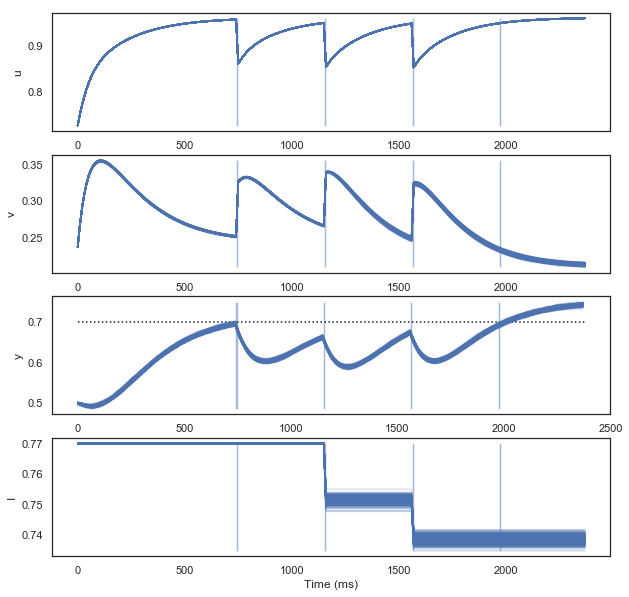

In [6]:
sigma = 0.01
I = 0.77
K = 5.0
duration = 400

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=4, duration=duration, sigma=sigma, 
                                                       K=K, initI=I)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2))
times = times[(times > 0) & (times != np.inf)]
print('Mean decision time is ', np.mean(times))

# Save the parameters in a .mat file
#scipy.io.savemat('PlotTools/uv_simulation_data020819_K5_00_I0_77_s0_01_400ms.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
#                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT,
#                                                   'sigma': sigma, 'K': K, 'I': I})

## Optimizing over a prior

### Ready, Set, Go task

Our prior will be a discrete uniform distribution 600, 700, ..., 1000 ms.

We simulate the 1-2-Go and 1-2-3-Go tasks below and calculate the MSE landscape. $(I, K)$ will be sampled from a grid of values.

In [7]:
def find_rmse(durations, ntrials, nstages, sigma, I, K, return_inf):
    '''Do multiple simulations to find the expected mse of the given set of parameters'''
    mse_total = 0
    for k, dur in enumerate(durations):
        times = get_time_lst(ntrials=ntrials, nstages=nstages,duration=dur, 
                             sigma=sigma, K=K, initI=I)
        # Consider invalid parameters that result in infinite decision times
        if len(times) < ntrials * 0.5:
            return np.inf
        mse_total += np.sum((times * 10 - dur)**2)
    return np.sqrt(mse_total / (ntrials * len(durations)))

In [8]:
def sampling_IK_grid(sigma_lst, Ilst, Klst, durations, nstages, ntrials, return_inf=True):
    '''Perform a simulation to find the rmse of the parameters in the grid.
    Returns a list of nI x nK arrays corresponding to each sigma'''
    # Start of main loop
    mse_arr = np.zeros((len(sigma_lst), len(Ilst), len(Klst)))
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for id_i, I in enumerate(Ilst):
            for id_k, K in enumerate(Klst):
                rmse = find_rmse(durations, ntrials=ntrials, nstages=nstages, 
                                 sigma=sigma, I=I, K=K, return_inf=return_inf)
                mse_arr[id_s, id_i, id_k] = rmse
                print('    I = %.4f, K = %.4f, RMSE = %.4f' % (I, K, rmse))
    return mse_arr

In [41]:
# Trial duration is uniformly sampled from in [600, 1000]
durations = np.linspace(600, 1000, 5)
sigma_lst = [0.005] #np.linspace(0.005, 0.03, 6)

# Define the grid of I and K values
nK = 30
nI = 30
Klst = np.linspace(2, 8, nK)
Ilst = np.linspace(0.775, 0.785, nI)

# Perform the grid simulation
grid_sim_result = sampling_IK_grid(sigma_lst, Ilst, Klst, durations, nstages=4, ntrials=1000,
                                  return_inf=False)

#TODO: Deal with infinite times more properly

*** sigma =  0.005  ***
    I = 0.7750, K = 2.0000, RMSE = 104.5393
    I = 0.7750, K = 2.2069, RMSE = 100.1510
    I = 0.7750, K = 2.4138, RMSE = 95.5760
    I = 0.7750, K = 2.6207, RMSE = 90.2836
    I = 0.7750, K = 2.8276, RMSE = 86.0385
    I = 0.7750, K = 3.0345, RMSE = 82.7810
    I = 0.7750, K = 3.2414, RMSE = 77.9656
    I = 0.7750, K = 3.4483, RMSE = 74.8206
    I = 0.7750, K = 3.6552, RMSE = 70.0627
    I = 0.7750, K = 3.8621, RMSE = 66.5510
    I = 0.7750, K = 4.0690, RMSE = 63.4980
    I = 0.7750, K = 4.2759, RMSE = 61.4942
    I = 0.7750, K = 4.4828, RMSE = 59.3512
    I = 0.7750, K = 4.6897, RMSE = 55.0572
    I = 0.7750, K = 4.8966, RMSE = 54.4057
    I = 0.7750, K = 5.1034, RMSE = 53.5756
    I = 0.7750, K = 5.3103, RMSE = 51.3110
    I = 0.7750, K = 5.5172, RMSE = 51.2295
    I = 0.7750, K = 5.7241, RMSE = 48.0333
    I = 0.7750, K = 5.9310, RMSE = 49.4585
    I = 0.7750, K = 6.1379, RMSE = 48.5671
    I = 0.7750, K = 6.3448, RMSE = 51.2443
    I = 0.7750, K = 6.5517, 

    I = 0.7771, K = 4.0690, RMSE = 54.5690
    I = 0.7771, K = 4.2759, RMSE = 52.3580
    I = 0.7771, K = 4.4828, RMSE = 51.0241
    I = 0.7771, K = 4.6897, RMSE = 50.2671
    I = 0.7771, K = 4.8966, RMSE = 48.6128
    I = 0.7771, K = 5.1034, RMSE = 48.8330
    I = 0.7771, K = 5.3103, RMSE = 46.9270
    I = 0.7771, K = 5.5172, RMSE = 47.6130
    I = 0.7771, K = 5.7241, RMSE = 48.9220
    I = 0.7771, K = 5.9310, RMSE = 48.6025
    I = 0.7771, K = 6.1379, RMSE = 49.1945
    I = 0.7771, K = 6.3448, RMSE = 51.7471
    I = 0.7771, K = 6.5517, RMSE = 51.1713
    I = 0.7771, K = 6.7586, RMSE = 51.6658
    I = 0.7771, K = 6.9655, RMSE = 52.7257
    I = 0.7771, K = 7.1724, RMSE = 52.1237
    I = 0.7771, K = 7.3793, RMSE = 53.2943
    I = 0.7771, K = 7.5862, RMSE = 55.1899
    I = 0.7771, K = 7.7931, RMSE = 56.8681
    I = 0.7771, K = 8.0000, RMSE = 61.2657
    I = 0.7774, K = 2.0000, RMSE = 86.0283
    I = 0.7774, K = 2.2069, RMSE = 81.5436
    I = 0.7774, K = 2.4138, RMSE = 76.9975
    I = 0.7

    I = 0.7791, K = 6.3448, RMSE = 50.2633
    I = 0.7791, K = 6.5517, RMSE = 50.1143
    I = 0.7791, K = 6.7586, RMSE = 51.4259
    I = 0.7791, K = 6.9655, RMSE = 52.9420
    I = 0.7791, K = 7.1724, RMSE = 54.9207
    I = 0.7791, K = 7.3793, RMSE = 54.7936
    I = 0.7791, K = 7.5862, RMSE = 55.7527
    I = 0.7791, K = 7.7931, RMSE = 58.0417
    I = 0.7791, K = 8.0000, RMSE = 57.7256
    I = 0.7795, K = 2.0000, RMSE = 84.1560
    I = 0.7795, K = 2.2069, RMSE = 78.5174
    I = 0.7795, K = 2.4138, RMSE = 73.0567
    I = 0.7795, K = 2.6207, RMSE = 68.7876
    I = 0.7795, K = 2.8276, RMSE = 64.3975
    I = 0.7795, K = 3.0345, RMSE = 61.0804
    I = 0.7795, K = 3.2414, RMSE = 58.5727
    I = 0.7795, K = 3.4483, RMSE = 55.8115
    I = 0.7795, K = 3.6552, RMSE = 53.8557
    I = 0.7795, K = 3.8621, RMSE = 51.3909
    I = 0.7795, K = 4.0690, RMSE = 49.8161
    I = 0.7795, K = 4.2759, RMSE = 48.5026
    I = 0.7795, K = 4.4828, RMSE = 47.9646
    I = 0.7795, K = 4.6897, RMSE = 47.9575
    I = 0.7

    I = 0.7816, K = 2.4138, RMSE = 89.9043
    I = 0.7816, K = 2.6207, RMSE = 83.2919
    I = 0.7816, K = 2.8276, RMSE = 77.8808
    I = 0.7816, K = 3.0345, RMSE = 72.1135
    I = 0.7816, K = 3.2414, RMSE = 67.5050
    I = 0.7816, K = 3.4483, RMSE = 62.5420
    I = 0.7816, K = 3.6552, RMSE = 58.0682
    I = 0.7816, K = 3.8621, RMSE = 57.2549
    I = 0.7816, K = 4.0690, RMSE = 54.3428
    I = 0.7816, K = 4.2759, RMSE = 53.8947
    I = 0.7816, K = 4.4828, RMSE = 49.8139
    I = 0.7816, K = 4.6897, RMSE = 49.6594
    I = 0.7816, K = 4.8966, RMSE = 49.0606
    I = 0.7816, K = 5.1034, RMSE = 47.8088
    I = 0.7816, K = 5.3103, RMSE = 47.1565
    I = 0.7816, K = 5.5172, RMSE = 49.6506
    I = 0.7816, K = 5.7241, RMSE = 49.3662
    I = 0.7816, K = 5.9310, RMSE = 48.7717
    I = 0.7816, K = 6.1379, RMSE = 50.7218
    I = 0.7816, K = 6.3448, RMSE = 49.2727
    I = 0.7816, K = 6.5517, RMSE = 51.7828
    I = 0.7816, K = 6.7586, RMSE = 53.2368
    I = 0.7816, K = 6.9655, RMSE = 54.8279
    I = 0.7

    I = 0.7836, K = 4.4828, RMSE = 58.7946
    I = 0.7836, K = 4.6897, RMSE = 57.7621
    I = 0.7836, K = 4.8966, RMSE = 53.6669
    I = 0.7836, K = 5.1034, RMSE = 52.7794
    I = 0.7836, K = 5.3103, RMSE = 52.4385
    I = 0.7836, K = 5.5172, RMSE = 49.6747
    I = 0.7836, K = 5.7241, RMSE = 49.4413
    I = 0.7836, K = 5.9310, RMSE = 48.4198
    I = 0.7836, K = 6.1379, RMSE = 49.3684
    I = 0.7836, K = 6.3448, RMSE = 49.9914
    I = 0.7836, K = 6.5517, RMSE = 50.6318
    I = 0.7836, K = 6.7586, RMSE = 53.3548
    I = 0.7836, K = 6.9655, RMSE = 52.6338
    I = 0.7836, K = 7.1724, RMSE = 53.6162
    I = 0.7836, K = 7.3793, RMSE = 56.1939
    I = 0.7836, K = 7.5862, RMSE = 55.4206
    I = 0.7836, K = 7.7931, RMSE = 57.2512
    I = 0.7836, K = 8.0000, RMSE = 57.6534
    I = 0.7840, K = 2.0000, RMSE = 175.4319
    I = 0.7840, K = 2.2069, RMSE = 158.4484
    I = 0.7840, K = 2.4138, RMSE = 144.0508
    I = 0.7840, K = 2.6207, RMSE = 130.0046
    I = 0.7840, K = 2.8276, RMSE = 115.3209
    I 

In [43]:
scipy.io.savemat('PlotTools/IK_grid_020919_1000trialsB.mat', {'MSELST': grid_sim_result,
                                                          'Klst': Klst,
                                                          'Ilst': Ilst,
                                                            'sigma_lst': sigma_lst})

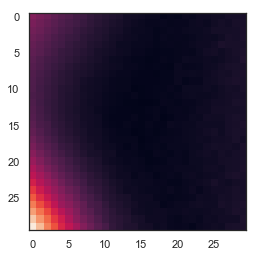

In [42]:
plt.imshow(grid_sim_result[0])

Instead of sampling from a grid of $(I, K)$, here we do a random sampling of $(I, K)$.

In [9]:
# TODO: Check if the old and new versions give the same results
def sampling_IK_optimization_old(sigma_lst, nstages, nsamples=100, maxiter=5):
    '''Perform optimization of (I, K), given parameters sigma'''
    durations = np.linspace(600, 1000, 5)
    ILST = np.zeros((len(sigma_lst), maxiter))
    KLST = np.zeros((len(sigma_lst), maxiter))

    # Do simulation several times to obtain error bars
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for niter in range(maxiter):
            print('    Running iteration #', niter)
            # For each iteration, re-pick list of I and K
            Klst = np.random.uniform(low=1, high=10, size=nsamples)
            initIlst = np.random.uniform(low=0.77, high=0.8, size=nsamples)

            mse_lst = np.zeros(nsamples)
            for i in range(nsamples):
                I = initIlst[i]
                K = Klst[i]
                mse_total = 0
                #print('        Doing time I = %f. K = %f' % (I, K))
                for k, dur in enumerate(durations):
                    #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                           duration=dur, sigma=sigma, K=K, initI=I)

                    Ylst2 = np.array(ylst2)
                    times = get_times_lst_from_y(np.array(Ylst2))
                    times = times[(times > 0) & (times != np.inf)]

                    if len(times) < 100:
                        mse_total = np.inf
                        #print('no time')
                        break
                    mse_total += np.sum((times * 10 - dur)**2)
                    #print('          times:', times)

                mse_lst[i] = np.sqrt(np.mean(mse_total))
                #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
                #bar.next()
            # Determine the arg-min of the list
            argmin = np.argsort(mse_lst)
            Kmin = Klst[argmin[0]]
            Imin = initIlst[argmin[0]]
            KLST[id_s][niter] = Kmin
            ILST[id_s][niter] = Imin
            print('        Kmin = ', Kmin, ', Imin =', Imin)
    return ILST, KLST

In [10]:
def sampling_IK_optimization(durations, sigma_lst, nstages, ntrials, 
                             Klow, Khigh, Ilow, Ihigh, nsamples=100, maxiter=5):
    '''Perform optimization of (I, K), given parameters sigma'''
    I_optimal = np.zeros((len(sigma_lst), maxiter))
    K_optimal = np.zeros((len(sigma_lst), maxiter))

    # Do simulation several times to obtain error bars
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for niter in range(maxiter):
            print('    Running iteration #', niter)
            # For each iteration, re-pick list of I and K
            Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
            Ilst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

            mse_lst = np.zeros(nsamples)
            for i in range(nsamples):
                I = Ilst[i]
                K = Klst[i]
                rmse = find_rmse(durations, ntrials=ntrials, nstages=nstages, 
                                 sigma=sigma, I=I, K=K, return_inf=True)
                mse_lst[i] = rmse
                #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            # Determine the arg-min of the list
            argmin = np.argsort(mse_lst)
            Kmin = Klst[argmin[0]]
            Imin = Ilst[argmin[0]]
            K_optimal[id_s][niter] = Kmin
            I_optimal[id_s][niter] = Imin
            print('        Kmin = ', Kmin, ', Imin =', Imin)
    return I_optimal, K_optimal

In [13]:
durations = np.linspace(600, 1000, 5)
sampling_IK_optimization(durations, [0.0166], nstages=3, ntrials=100, 
                         Klow= 1, Khigh=10, Ilow=0.77, Ihigh=0.8, nsamples=100, maxiter=10)

*** sigma =  0.0166  ***
    Running iteration # 0
        Kmin =  5.215737983811514 , Imin = 0.7808749549979628
    Running iteration # 1
        Kmin =  5.801200810397531 , Imin = 0.7759692648378855
    Running iteration # 2
        Kmin =  6.009774874975201 , Imin = 0.7792339733489502
    Running iteration # 3
        Kmin =  5.424073279017028 , Imin = 0.7809584844517299
    Running iteration # 4
        Kmin =  5.588877919351707 , Imin = 0.779980497161704
    Running iteration # 5
        Kmin =  3.8458550042208026 , Imin = 0.7799999141972802
    Running iteration # 6
        Kmin =  4.158518635701433 , Imin = 0.77793485765365
    Running iteration # 7
        Kmin =  5.9424243337083364 , Imin = 0.7779664407931165
    Running iteration # 8
        Kmin =  5.0419676680901855 , Imin = 0.7786110598365469
    Running iteration # 9
        Kmin =  5.822198723099146 , Imin = 0.7791987189079845


(array([[0.78087495, 0.77596926, 0.77923397, 0.78095848, 0.7799805 ,
         0.77999991, 0.77793486, 0.77796644, 0.77861106, 0.77919872]]),
 array([[5.21573798, 5.80120081, 6.00977487, 5.42407328, 5.58887792,
         3.845855  , 4.15851864, 5.94242433, 5.04196767, 5.82219872]]))

In [66]:
sigma_lst = np.linspace(0.001, 0.04, 6)

Iresults = []
Kresults = []

for i in np.arange(3, 14):
    print('### Number of iterations = ', i)
    a, b = sampling_IK_optimization(sigma_lst, i, nsamples=100, maxiter=10)
    Iresults.append(a)
    Kresults.append(b)

### Number of iterations =  3
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  7.673730767661788 , Imin = 0.7820406065880282
    Running iteration # 1
        Kmin =  8.324289521569298 , Imin = 0.7761776386337822
    Running iteration # 2
        Kmin =  7.85008449339766 , Imin = 0.7798098148823759
    Running iteration # 3
        Kmin =  7.6345425690700415 , Imin = 0.7885053736113045
    Running iteration # 4
        Kmin =  7.6124906385402085 , Imin = 0.786384469916521
    Running iteration # 5
        Kmin =  8.492132297535992 , Imin = 0.7721192860757722
    Running iteration # 6
        Kmin =  8.106508407795484 , Imin = 0.7795008207135184
    Running iteration # 7
        Kmin =  7.737545604258462 , Imin = 0.7814255101489166
    Running iteration # 8
        Kmin =  7.605735201193798 , Imin = 0.7838884364034141
    Running iteration # 9
        Kmin =  8.378245319273846 , Imin = 0.7726549016352496
*** sigma =  0.008799999999999999  ***
    Running iteration # 0
 

        Kmin =  3.9160719580672674 , Imin = 0.7822992359867926
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  4.347565695930931 , Imin = 0.7809632053455122
    Running iteration # 1
        Kmin =  2.891411626993391 , Imin = 0.7803006987449969
    Running iteration # 2
        Kmin =  3.1609216278298646 , Imin = 0.7809005997501666
    Running iteration # 3
        Kmin =  2.714064812308277 , Imin = 0.7807043604859164
    Running iteration # 4
        Kmin =  4.665256184014793 , Imin = 0.7854255190578542
    Running iteration # 5
        Kmin =  2.230996038833317 , Imin = 0.7794012580871142
    Running iteration # 6
        Kmin =  2.8053544256143605 , Imin = 0.7790128398935128
    Running iteration # 7
        Kmin =  2.7918909759584065 , Imin = 0.7792086170388626
    Running iteration # 8
        Kmin =  3.1122299719888993 , Imin = 0.7824873130489469
    Running iteration # 9
        Kmin =  2.664947022329865 , Imin = 0.7786404706027586
*** sigma =  0

        Kmin =  1.838665873940163 , Imin = 0.7846040029922625
### Number of iterations =  6
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  4.8008281270350235 , Imin = 0.7842600546542201
    Running iteration # 1
        Kmin =  4.412516397585406 , Imin = 0.7829001755258567
    Running iteration # 2
        Kmin =  4.6768717571200975 , Imin = 0.7873690727602667
    Running iteration # 3
        Kmin =  4.246549651170017 , Imin = 0.782450442595593
    Running iteration # 4
        Kmin =  5.161514115495913 , Imin = 0.7809279840961586
    Running iteration # 5
        Kmin =  4.029567821470125 , Imin = 0.780794123287461
    Running iteration # 6
        Kmin =  4.279605794613594 , Imin = 0.782003327689772
    Running iteration # 7
        Kmin =  4.39790581076422 , Imin = 0.7802613072177523
    Running iteration # 8
        Kmin =  4.792613517114886 , Imin = 0.7870624454848111
    Running iteration # 9
        Kmin =  4.615877535056741 , Imin = 0.7810774343856078
*** si

        Kmin =  2.092756484660871 , Imin = 0.7807763452087226
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  2.4242694049100537 , Imin = 0.789748492759085
    Running iteration # 1
        Kmin =  3.497242916206817 , Imin = 0.7896850745101444
    Running iteration # 2
        Kmin =  3.5624340216090133 , Imin = 0.7998592161008532
    Running iteration # 3
        Kmin =  3.04979665552465 , Imin = 0.7893813772810747
    Running iteration # 4
        Kmin =  2.8270111461263254 , Imin = 0.7904271742366423
    Running iteration # 5
        Kmin =  2.6459771106748455 , Imin = 0.7757134708435752
    Running iteration # 6
        Kmin =  2.3017515363846055 , Imin = 0.7838273925939915
    Running iteration # 7
        Kmin =  2.671662168131985 , Imin = 0.7934555738641829
    Running iteration # 8
        Kmin =  2.3068317758082446 , Imin = 0.7804310383984262
    Running iteration # 9
        Kmin =  2.1359242201028925 , Imin = 0.7782219032114218
*** sigma =  0

        Kmin =  1.7751414413126745 , Imin = 0.7890733971007038
### Number of iterations =  9
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  3.513613382699635 , Imin = 0.7829472844291644
    Running iteration # 1
        Kmin =  3.1813233088113386 , Imin = 0.7842661274902315
    Running iteration # 2
        Kmin =  3.7641555986324975 , Imin = 0.7840216431186154
    Running iteration # 3
        Kmin =  2.929839666939568 , Imin = 0.7811823804297474
    Running iteration # 4
        Kmin =  3.28115577955009 , Imin = 0.7830963606603735
    Running iteration # 5
        Kmin =  3.0765576664725445 , Imin = 0.7818356277388714
    Running iteration # 6
        Kmin =  3.951862459995916 , Imin = 0.7852963178237854
    Running iteration # 7
        Kmin =  3.9642180144359465 , Imin = 0.7892050333813189
    Running iteration # 8
        Kmin =  3.030605971204968 , Imin = 0.7784475344907322
    Running iteration # 9
        Kmin =  2.8662822544564817 , Imin = 0.7838147600069526

        Kmin =  2.230002525934539 , Imin = 0.7907934244423996
    Running iteration # 9
        Kmin =  1.5388375710274198 , Imin = 0.7812072030702757
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  1.668242677216242 , Imin = 0.7754570714042842
    Running iteration # 1
        Kmin =  2.037626018523023 , Imin = 0.7918834423175277
    Running iteration # 2
        Kmin =  2.050537132491844 , Imin = 0.7972330204291227
    Running iteration # 3
        Kmin =  1.936261683116156 , Imin = 0.7971162991607756
    Running iteration # 4
        Kmin =  1.8360205476980394 , Imin = 0.789292020467803
    Running iteration # 5
        Kmin =  1.3409044930777938 , Imin = 0.7833142990967668
    Running iteration # 6
        Kmin =  1.5186001495711348 , Imin = 0.7812087214278607
    Running iteration # 7
        Kmin =  1.696936970688157 , Imin = 0.7890794469086749
    Running iteration # 8
        Kmin =  2.4279818511940157 , Imin = 0.794870027600784
    Running iter

        Kmin =  1.2642206299999326 , Imin = 0.7876572213761059
    Running iteration # 9
        Kmin =  1.9253361730655036 , Imin = 0.7946742905911894
### Number of iterations =  12
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  2.67913487244346 , Imin = 0.783897112238661
    Running iteration # 1
        Kmin =  3.8172772512464803 , Imin = 0.7917527474385953
    Running iteration # 2
        Kmin =  3.0724660515720474 , Imin = 0.7887368193365764
    Running iteration # 3
        Kmin =  2.7358001945648427 , Imin = 0.7849538673471145
    Running iteration # 4
        Kmin =  2.5521621651752175 , Imin = 0.7838583190806431
    Running iteration # 5
        Kmin =  2.5091735204584706 , Imin = 0.7840808600518222
    Running iteration # 6
        Kmin =  2.680359197169763 , Imin = 0.7864288281795049
    Running iteration # 7
        Kmin =  2.801317392011964 , Imin = 0.7917068615584749
    Running iteration # 8
        Kmin =  2.202484392010545 , Imin = 0.779825260758331

        Kmin =  1.2166242085702246 , Imin = 0.786466081257922
    Running iteration # 8
        Kmin =  1.7983460289950806 , Imin = 0.7848349854449536
    Running iteration # 9
        Kmin =  1.1112976823178586 , Imin = 0.7842667248494247
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  1.312609893279984 , Imin = 0.7928614148101649
    Running iteration # 1
        Kmin =  1.4092912149782086 , Imin = 0.7895736387499278
    Running iteration # 2
        Kmin =  1.3848914824271454 , Imin = 0.7812624090609137
    Running iteration # 3
        Kmin =  2.2440358442150674 , Imin = 0.7845302152595244
    Running iteration # 4
        Kmin =  1.4766004148410552 , Imin = 0.7920976774276964
    Running iteration # 5
        Kmin =  1.063411765681075 , Imin = 0.7883403405377285
    Running iteration # 6
        Kmin =  1.9231865351044344 , Imin = 0.7883729963625988
    Running iteration # 7
        Kmin =  2.037754740042767 , Imin = 0.7791529924437111
    Running 

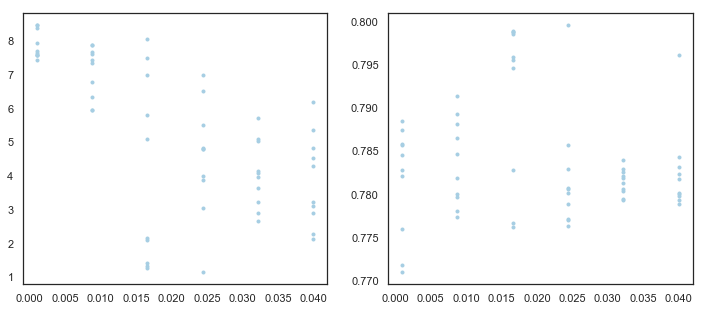

In [37]:
# Color schemes
colors = np.array([[166,206,227],
                [31,120,180],
                [178,223,138],
                [51,160,44],
                [251,154,153]]) / 255

# Load subject fit data
data = scipy.io.loadmat('PlotTools/IK_subject_fit_020519_thres0_7_constant_stage0_750ms_optimized3.mat')
combi_arr = data['combi_arr']

plt.figure(figsize=(12, 5))
# K plotting
plt.subplot(121)
#plt.plot(combi_arr2[:,0], combi_arr[:,2], 'rx')

for i in range(1):
    plt.plot(sigma_lst, Kresults[i], '.', color=colors[i])

# I plotting
plt.subplot(122)

#plt.plot(combi_arr2[:,0], combi_arr[:,1], 'rx')
for i in range(1):
    plt.plot(sigma_lst, Iresults[i], '.', color=colors[i])

In [ ]:
import time

### Doing random sampling for (I,K)

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

sigma_lst = np.linspace(0.005, 0.04, 10)

nsamples = 100
nstages = 10

maxiter = 3
ILST = np.zeros((len(sigma_lst), maxiter))
KLST = np.zeros((len(sigma_lst), maxiter))

#Klst = np.linspace(0.5, 3.5, nsamples)

#bar = Bar('Processing', max=1000)
#bar.start()

start = time.time()

# Do simulation several times to obtain error bars
for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    for niter in range(maxiter):
        print('    Running iteration #', niter)
        # For each iteration, re-pick list of I and K
        Klst = np.random.uniform(low=1, high=6, size=nsamples)
        Ilst = np.random.uniform(low=0.77, high=0.79, size=nsamples)
    
        mse_lst = np.zeros(nsamples)
        for i in range(nsamples):
            I = Ilst[i]
            K = Klst[i]
            mse_total = 0
            #print('        Doing time I = %f. K = %f' % (I, K))
            for k, dur in enumerate(durations):
                #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - dur)**2)

            mse_lst[i] = np.sqrt(np.mean(mse_total))
            #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            #bar.next()
        # Determine the arg-min of the list
        argmin = np.argsort(mse_lst)
        Kmin = Klst[argmin[0]]
        Imin = Ilst[argmin[0]]
        KLST[id_s][niter] = Kmin
        ILST[id_s][niter] = Imin
        print('        Kmin = ', Kmin, ', Imin =', Imin)

end = time.time()
print('Time taken = ', end - start)
# Save simulation results
#scipy.io.savemat('PlotTools/IK_optimization_data_I_0_78_1000trials.mat', {'Ilst': Ilst, 'Klst': Klst, 'KLST': KLST, 
#                                                  'ILST': ILST, 'sigma_lst': sigma_lst, 'PARAMS': PARAMS_DICT})
        
#bar.finish()
    
#plt.plot(Ilst, mse_lst)

*** sigma =  0.005  ***
    Running iteration # 0
        Kmin =  2.9756737834911386 , Imin = 0.7805323734141542
    Running iteration # 1
        Kmin =  3.8889902946802253 , Imin = 0.7821754462710986
    Running iteration # 2
        Kmin =  2.6181556944540483 , Imin = 0.7802945176936206
*** sigma =  0.008888888888888889  ***
    Running iteration # 0
        Kmin =  3.238908181153839 , Imin = 0.776205010753333
    Running iteration # 1
        Kmin =  3.5661133375027365 , Imin = 0.7866042658421407
    Running iteration # 2
        Kmin =  2.297364326199939 , Imin = 0.7768444786233386
*** sigma =  0.012777777777777779  ***
    Running iteration # 0
        Kmin =  2.4533558418962733 , Imin = 0.7811517579197104
    Running iteration # 1
        Kmin =  3.301470144112287 , Imin = 0.7789895258723817
    Running iteration # 2
        Kmin =  2.4762335547942667 , Imin = 0.7785702667443206
*** sigma =  0.016666666666666666  ***
    Running iteration # 0
        Kmin =  2.419460427301033 , 

Plotting the result of the simulation of optimized $(I, K)$ together with the fitted values.

In [200]:
scipy.io.savemat('PlotTools/IK_sim_relationship.mat', {'ILST': ILST, 'KLST': KLST,
                                            'sigma_lst': sigma_lst})

In [15]:
all_subject_files = ['SWE_EKF_ObsAct0_20171105.mat', 'CV_EKF_ObsAct0_20171105.mat',
                    'GB_EKF_ObsAct0_20171105.mat', 'LB_EKF_ObsAct0_20171105.mat',
                    'PG_EKF_ObsAct0_20171105.mat', 'SM_EKF_ObsAct0_20171105.mat',
                    'TA_EKF_ObsAct0_20171105.mat', 'VD_EKF_ObsAct0_20171105.mat',
                    'VR_EKF_ObsAct0_20171105.mat',
                    'SWE_EKF_ObsAct0_20171125.mat', 'GB_EKF_ObsAct0_20171125.mat']

[43.38617886 58.10679475 59.85395688 64.82285601 74.16884682]
[43.36735249 57.39464119 67.36902996 70.72701084 73.18907742]
Doing time # 0 = <module 'time' (built-in)>
Doing time # 1 = <module 'time' (built-in)>
Doing time # 2 = <module 'time' (built-in)>
Doing time # 3 = <module 'time' (built-in)>
Doing time # 4 = <module 'time' (built-in)>
RSG results:
Observed mean STD =  89.45925358249178
Simulated mean STD =  96.28334818536098
RSSG results:
Observed mean STD =  99.3156829134492
Simulated mean STD =  96.94717585258348
6758.114451062582
6292.027260788261


43041.10135471616

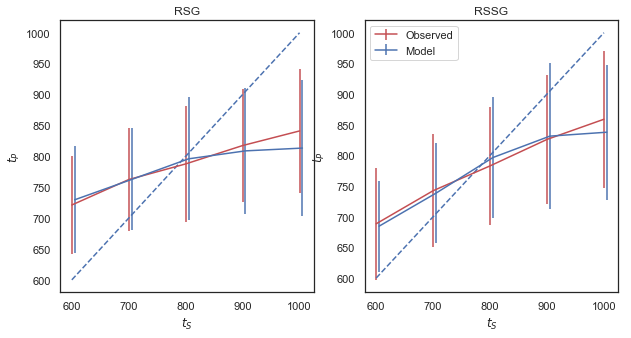

In [25]:
# Load data for subject GB (RSG/RSSG, Seth provided)
subject_file = all_subject_files[2]#'SWE_EKF_ObsAct0_20171105.mat'

#     (0.02338383838383839, 0.7791005481106896, 2.3264417072456043)

#I = 0.02338383838383839, K = 5.042443, sigma = 0.020556, error = 20638.847213
#1790.1702682916728
#1132.1413472659856

np.random.seed(111)

sigma_val = sigmas[2]
I_val = Iarr[2]
K_val = Karr[2]

target_std1 = stdtp_in[:,0]
target_std2 = stdtp_in[:,1]
target_time1 = mtp_in[:,0]
target_time2 = mtp_in[:,1]


print(target_std1)
print(target_std2)

subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, dur in enumerate(durations):
    times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigma_val, K=K_val, initI=I_val)
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, dur in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigma_val, K=K_val, initI=I_val)
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

print(np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2))
print(np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2))
#np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) +\
#                    np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)

np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) +\
                np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)



In [26]:
scipy.io.savemat('PlotTools/GB_sim_results_021119_with_warmup.mat', 
                 {'durations': durations, 'mtp_in': mtp_in, 'prod_time_lst': prod_time_lst,
                 'prod_time_lst2': prod_time_lst2, 'prod_var_lst': prod_var_lst,
                 'prod_var_lst2': prod_var_lst2, 'stdtp_in': stdtp_in, 'tss': tss})

## Behavior fitting protocol

The protocol has two parts: (1) Fitting $(I,K)$ and (2) Fitting $\sigma$. $(I, K)$ is fitted based on the mean of the distribution, while $\sigma$ is fitted based on the standard deviation.

### $(I,K)$ fitting

In [11]:
def do_IK_fitting(subject_file, sigmaval, nsamples, ntrials, Klow, Khigh, Ilow, Ihigh,
                 print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - sigmaval: sigma value to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    I, K: the optimal combination to minimize the mse between the mean simulated times
    and the mean behavioral times of the subject'''
    #print('sigmaval = ', sigmaval)
    Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
    Ilst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        Ival = Ilst[k]
        Kval = Klst[k]

        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=ntrials, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=ntrials, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))

        # Continue if there is a nan   
        error1 = (np.array(prod_time_lst) * 10 - target_time1) ** 2
        error2 = (np.array(prod_time_lst2) * 10 - target_time2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
        # Error function to minimize
            error = np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) +\
                    np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, sigma = %f, error = %f' %(Ival, Kval, sigmaval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal (I, K) = ', Ilst[idx], Klst[idx])
    return Ilst[idx], Klst[idx]

In [12]:
def do_sigma_fitting(subject_file, Ival, Kval, nsamples, ntrials, 
                     low, high, print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - Ival, Kval: I and K values to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    sigma: the optimal sigma to minimize the mse between the std simulated times
    and the std behavioral times of the subject'''

    sigmalst = np.linspace(low, high, nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_std1 = stdtp_in[:,0]
    target_std2 = stdtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        sigmaval = sigmalst[k]
        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))
            
        # Continue if there is a nan   
        error1 = (np.array(prod_var_lst) * 10 - target_std1) ** 2
        error2 = (np.array(prod_var_lst2) * 10 - target_std2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
            # Error function to minimize
            error = np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) +\
                    np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)
        
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, sigma = %f, error = %f' %(Ival, Kval, sigmaval, error))
            #print(np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2))
            #print(np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal sigma = ', sigmalst[idx], 'error =', error)
    #print(sum(target_std1))
    #print(sum(target_std2))
    return sigmalst[idx]

In [13]:
def subject_fitting(subject_file, nsamples, nsamples2, ntrials,
                    Klow, Khigh, Ilow, Ihigh, 
                    sigmalow, sigmahigh, print_every=10, niter=5, sigma_init=0.02):
    '''Optimize for the given subject file,
    Returns the fitted combination (sigma, I, K)'''
    sigmaval = sigma_init
    for i in range(niter):
        Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, ntrials=ntrials,
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
        sigmaval = do_sigma_fitting(subject_file, Ival=Ival, Kval=Kval, nsamples=nsamples2, ntrials=ntrials,
                                    low=sigmalow, high=sigmahigh, print_every=print_every)
    # One last round of IK fitting
    Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, ntrials=ntrials,
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
    return sigmaval, Ival, Kval
    
    

In [16]:
#all_subject_files = ['SWE_EKF_ObsAct0_20171125.mat', 'GB_EKF_ObsAct0_20171125.mat']
np.random.seed(123)
combi_collection = []
for subject_file in all_subject_files:
    print(' ********* Doing subject file %s ************' % subject_file)
    combi = subject_fitting(subject_file, nsamples=1000, nsamples2=100, ntrials=100, Klow=1.0, Khigh=8.0, 
                            Ilow=0.77, Ihigh=0.79, sigmalow=0.005, sigmahigh=0.04, print_every=50)
    combi_collection.append(combi)

 ********* Doing subject file SWE_EKF_ObsAct0_20171105.mat ************
    I = 0.771638, K = 5.875284, sigma = 0.020000, error = 34849.468835
    I = 0.783961, K = 1.844401, sigma = 0.020000, error = 166238.935322
    I = 0.773754, K = 4.591897, sigma = 0.020000, error = 46701.827954
    I = 0.782240, K = 2.161565, sigma = 0.020000, error = 70942.521024
    I = 0.786389, K = 4.798451, sigma = 0.020000, error = 31682.334672
    I = 0.778417, K = 2.457738, sigma = 0.020000, error = 50479.689541
    I = 0.773601, K = 1.114747, sigma = 0.020000, error = 161282.308190
    I = 0.789450, K = 5.967363, sigma = 0.020000, error = 17572.690172
    I = 0.788313, K = 4.193894, sigma = 0.020000, error = 111250.859012
    I = 0.771059, K = 1.653989, sigma = 0.020000, error = 210219.017261
    I = 0.779209, K = 2.489820, sigma = 0.020000, error = 34006.748220
    I = 0.772594, K = 4.973019, sigma = 0.020000, error = 51653.130085
    I = 0.779465, K = 5.909519, sigma = 0.020000, error = 5277.997392
  

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan encountered
nan encountered
    I = 0.779213, K = 5.498035, sigma = 0.006414, error = 1973.549918
Optimal (I, K) =  0.7781214561200683 5.160670147277925
    I = 0.778121, K = 5.160670, sigma = 0.005000, error = 5977.417708
    I = 0.778121, K = 5.160670, sigma = 0.022677, error = 37029.410717
Optimal sigma =  0.008181818181818182 error = 101609.80422240005
    I = 0.787740, K = 6.937706, sigma = 0.008182, error = 18510.195611
    I = 0.779898, K = 5.626873, sigma = 0.008182, error = 4714.243684
    I = 0.771998, K = 5.720122, sigma = 0.008182, error = 17316.479977
    I = 0.788826, K = 7.178189, sigma = 0.008182, error = 18080.600985
    I = 0.787089, K = 7.619530, sigma = 0.008182, error = 12176.934266
    I = 0.772631, K = 3.828927, sigma = 0.008182, error = 53022.169178
    I = 0.784089, K = 6.521110, sigma = 0.008182, error = 18853.755645
    I = 0.788061, K = 1.346876, sigma = 0.008182, error = 2880032.382871
    I = 0.778767, K = 1.239272, sigma = 0.008182, error = 70688.5688

    I = 0.772063, K = 5.932832, sigma = 0.020000, error = 50157.345166
    I = 0.772898, K = 3.649899, sigma = 0.020000, error = 69976.984944
    I = 0.778834, K = 6.171630, sigma = 0.020000, error = 38012.105668
Optimal (I, K) =  0.7789643209830209 2.1742545254502
    I = 0.778964, K = 2.174255, sigma = 0.005000, error = 24922.802863
    I = 0.778964, K = 2.174255, sigma = 0.022677, error = 6187.922159
Optimal sigma =  0.02055555555555556 error = 17203.877355092336
    I = 0.789694, K = 7.058351, sigma = 0.020556, error = 44224.251824
    I = 0.776043, K = 1.322852, sigma = 0.020556, error = 33769.847107
    I = 0.774470, K = 4.704134, sigma = 0.020556, error = 40850.762782
    I = 0.776223, K = 7.402509, sigma = 0.020556, error = 48710.305383
    I = 0.786289, K = 2.173295, sigma = 0.020556, error = 242778.167899
    I = 0.771125, K = 5.395498, sigma = 0.020556, error = 63766.028447
    I = 0.778126, K = 7.879890, sigma = 0.020556, error = 47870.832025
    I = 0.776132, K = 2.142153,

    I = 0.785051, K = 3.060263, sigma = 0.016667, error = 144639.418660
    I = 0.786299, K = 2.540986, sigma = 0.016667, error = 309846.200137
    I = 0.780073, K = 6.299762, sigma = 0.016667, error = 42767.357999
    I = 0.784890, K = 4.616535, sigma = 0.016667, error = 70649.830512
    I = 0.784372, K = 4.398539, sigma = 0.016667, error = 53190.929993
    I = 0.774310, K = 7.501906, sigma = 0.016667, error = 49674.811541
Optimal (I, K) =  0.7785580704537862 2.5233341068913333
 ********* Doing subject file GB_EKF_ObsAct0_20171105.mat ************
    I = 0.770292, K = 4.086414, sigma = 0.020000, error = 67315.199091
    I = 0.788041, K = 7.987602, sigma = 0.020000, error = 48739.564022
    I = 0.787587, K = 6.559349, sigma = 0.020000, error = 50027.459549
    I = 0.772019, K = 1.780466, sigma = 0.020000, error = 97275.825254
    I = 0.773594, K = 3.282172, sigma = 0.020000, error = 41422.768209
    I = 0.789573, K = 3.371783, sigma = 0.020000, error = 384188.158882
    I = 0.782869, 

    I = 0.784499, K = 3.946349, sigma = 0.021263, error = 64959.716431
    I = 0.777817, K = 1.473185, sigma = 0.021263, error = 7820.518737
    I = 0.775284, K = 1.055474, sigma = 0.021263, error = 31494.563507
    I = 0.789143, K = 1.497321, sigma = 0.021263, error = 1066317.853540
    I = 0.780971, K = 2.833839, sigma = 0.021263, error = 12450.488989
    I = 0.771589, K = 4.678109, sigma = 0.021263, error = 50827.945731
    I = 0.784751, K = 7.917535, sigma = 0.021263, error = 45465.116545
Optimal (I, K) =  0.7788324930515999 2.5776824530700506
    I = 0.778832, K = 2.577682, sigma = 0.005000, error = 37267.872135
    I = 0.778832, K = 2.577682, sigma = 0.022677, error = 2394.976070
Optimal sigma =  0.023030303030303033 error = 10765.091001788085
    I = 0.785022, K = 2.484460, sigma = 0.023030, error = 129807.115146
    I = 0.785826, K = 1.839001, sigma = 0.023030, error = 300596.262369
    I = 0.786762, K = 1.690459, sigma = 0.023030, error = 387368.506257
    I = 0.777494, K = 5.

    I = 0.773238, K = 6.496720, sigma = 0.005707, error = 15651.377840
    I = 0.788356, K = 4.613093, sigma = 0.005707, error = 288368.403540
    I = 0.778066, K = 3.915070, sigma = 0.005707, error = 15743.955299
    I = 0.784671, K = 5.023591, sigma = 0.005707, error = 51543.857379
    I = 0.775137, K = 6.431383, sigma = 0.005707, error = 11840.745539
    I = 0.771409, K = 6.145073, sigma = 0.005707, error = 32111.152647
    I = 0.776062, K = 4.276155, sigma = 0.005707, error = 29904.151770
nan encountered
nan encountered
    I = 0.775167, K = 6.808280, sigma = 0.005707, error = 10649.793946
nan encountered
    I = 0.778267, K = 1.490445, sigma = 0.005707, error = 70734.306360
    I = 0.782148, K = 2.253244, sigma = 0.005707, error = 131459.516133
nan encountered
    I = 0.780624, K = 7.820914, sigma = 0.005707, error = 7606.151452
nan encountered
nan encountered
    I = 0.770566, K = 1.312683, sigma = 0.005707, error = 289226.683726
    I = 0.777578, K = 6.590643, sigma = 0.005707, 

Optimal sigma =  0.021969696969696972 error = 17431.633402706997
    I = 0.775514, K = 2.853296, sigma = 0.021970, error = 49646.463223
    I = 0.785367, K = 1.551998, sigma = 0.021970, error = 236191.040769
    I = 0.782585, K = 3.226618, sigma = 0.021970, error = 14193.840949
    I = 0.770850, K = 7.668890, sigma = 0.021970, error = 72317.960379
    I = 0.773377, K = 3.054212, sigma = 0.021970, error = 84903.208717
    I = 0.788757, K = 2.949215, sigma = 0.021970, error = 271860.102081
    I = 0.788193, K = 2.867606, sigma = 0.021970, error = 209866.483261
    I = 0.776056, K = 2.896949, sigma = 0.021970, error = 37673.892353
    I = 0.774451, K = 3.398548, sigma = 0.021970, error = 63371.477161
    I = 0.786726, K = 5.458693, sigma = 0.021970, error = 40509.923755
    I = 0.773130, K = 5.088533, sigma = 0.021970, error = 70510.801072
    I = 0.776326, K = 7.106555, sigma = 0.021970, error = 70493.846140
    I = 0.772527, K = 1.791315, sigma = 0.021970, error = 118967.072932
    I = 

    I = 0.786436, K = 6.745132, sigma = 0.022677, error = 85731.761000
Optimal sigma =  0.005 error = 166958.4181368347
    I = 0.782368, K = 4.470061, sigma = 0.005000, error = 36762.259369
nan encountered
nan encountered
nan encountered
nan encountered
    I = 0.789517, K = 3.212054, sigma = 0.005000, error = 1605073.429141
nan encountered
nan encountered
nan encountered
    I = 0.782989, K = 6.871013, sigma = 0.005000, error = 6930.721480
    I = 0.780324, K = 5.564081, sigma = 0.005000, error = 5503.489210
nan encountered
nan encountered
    I = 0.779378, K = 3.491521, sigma = 0.005000, error = 20747.533657
    I = 0.771454, K = 3.703210, sigma = 0.005000, error = 97793.212596
    I = 0.772465, K = 5.860609, sigma = 0.005000, error = 25178.467327
nan encountered
nan encountered
nan encountered
    I = 0.772133, K = 6.499818, sigma = 0.005000, error = 17584.568801
nan encountered
nan encountered
nan encountered
    I = 0.772233, K = 2.776054, sigma = 0.005000, error = 114130.743506


    I = 0.786927, K = 2.047727, sigma = 0.005354, error = 1992876.859551
    I = 0.777035, K = 4.040579, sigma = 0.005354, error = 17810.133195
nan encountered
    I = 0.774252, K = 7.364445, sigma = 0.005354, error = 6894.469108
nan encountered
    I = 0.776859, K = 7.927615, sigma = 0.005354, error = 7126.325051
nan encountered
nan encountered
    I = 0.783955, K = 2.996787, sigma = 0.005354, error = 231556.936659
nan encountered
nan encountered
    I = 0.775596, K = 5.100651, sigma = 0.005354, error = 15617.722073
    I = 0.774997, K = 7.713368, sigma = 0.005354, error = 6742.502373
nan encountered
    I = 0.782872, K = 5.225386, sigma = 0.005354, error = 24622.161792
    I = 0.770077, K = 5.664798, sigma = 0.005354, error = 41888.627246
    I = 0.773822, K = 4.607011, sigma = 0.005354, error = 37014.610939
nan encountered
    I = 0.782278, K = 3.762780, sigma = 0.005354, error = 55990.058083
nan encountered
nan encountered
Optimal (I, K) =  0.7793550703783961 6.610750866472128
 ***

    I = 0.773426, K = 5.904115, sigma = 0.020556, error = 96397.334296
    I = 0.785787, K = 6.761070, sigma = 0.020556, error = 98572.575570
    I = 0.779936, K = 3.073293, sigma = 0.020556, error = 14873.533139
    I = 0.779372, K = 5.637878, sigma = 0.020556, error = 67290.161981
    I = 0.780614, K = 7.462105, sigma = 0.020556, error = 97074.344384
    I = 0.772137, K = 3.229720, sigma = 0.020556, error = 160633.516090
    I = 0.770360, K = 2.061552, sigma = 0.020556, error = 238212.369886
    I = 0.777397, K = 2.459258, sigma = 0.020556, error = 44589.287684
    I = 0.777372, K = 2.058699, sigma = 0.020556, error = 40943.162936
    I = 0.771718, K = 4.130153, sigma = 0.020556, error = 142374.985607
    I = 0.774640, K = 2.845419, sigma = 0.020556, error = 91121.323584
    I = 0.777757, K = 4.529377, sigma = 0.020556, error = 58317.270153
    I = 0.770122, K = 7.303866, sigma = 0.020556, error = 107553.135053
    I = 0.776087, K = 5.189542, sigma = 0.020556, error = 77867.278661
Op

    I = 0.783620, K = 1.384400, sigma = 0.024798, error = 156242.632069
    I = 0.775933, K = 4.107519, sigma = 0.024798, error = 23618.878903
    I = 0.773312, K = 2.498221, sigma = 0.024798, error = 55924.666296
    I = 0.785276, K = 5.274109, sigma = 0.024798, error = 55260.875759
    I = 0.776481, K = 2.452378, sigma = 0.024798, error = 11852.282253
    I = 0.778008, K = 2.261067, sigma = 0.024798, error = 4149.818890
    I = 0.777271, K = 4.886594, sigma = 0.024798, error = 29192.925621
    I = 0.786775, K = 3.980835, sigma = 0.024798, error = 85421.485009
    I = 0.787589, K = 3.394849, sigma = 0.024798, error = 156116.935596
    I = 0.771042, K = 5.890434, sigma = 0.024798, error = 53382.300756
    I = 0.772773, K = 5.328986, sigma = 0.024798, error = 50563.858587
    I = 0.788424, K = 4.661478, sigma = 0.024798, error = 72684.801099
    I = 0.788321, K = 1.045969, sigma = 0.024798, error = 881162.686249
    I = 0.786855, K = 2.795113, sigma = 0.024798, error = 194251.328340
   

    I = 0.770224, K = 4.832033, sigma = 0.023737, error = 28838.430803
    I = 0.780699, K = 3.428257, sigma = 0.023737, error = 45578.268846
    I = 0.783718, K = 7.962434, sigma = 0.023737, error = 74176.722995
    I = 0.779128, K = 2.389050, sigma = 0.023737, error = 24285.609162
    I = 0.775303, K = 2.926869, sigma = 0.023737, error = 5648.278088
    I = 0.772975, K = 1.057921, sigma = 0.023737, error = 23371.664161
    I = 0.780883, K = 1.947467, sigma = 0.023737, error = 71218.597643
    I = 0.775204, K = 5.714874, sigma = 0.023737, error = 30008.806841
    I = 0.773092, K = 5.832825, sigma = 0.023737, error = 27140.754359
    I = 0.789067, K = 1.734523, sigma = 0.023737, error = 955171.060386
    I = 0.772958, K = 3.784104, sigma = 0.023737, error = 12291.946940
    I = 0.782073, K = 6.796303, sigma = 0.023737, error = 75029.950347
    I = 0.785002, K = 4.006041, sigma = 0.023737, error = 135246.646372
    I = 0.789834, K = 6.022384, sigma = 0.023737, error = 138563.764781
    

nan encountered
    I = 0.787122, K = 7.130868, sigma = 0.006061, error = 18267.944166
    I = 0.780160, K = 7.711564, sigma = 0.006061, error = 10552.950953
nan encountered
nan encountered
nan encountered
nan encountered
    I = 0.785666, K = 2.695266, sigma = 0.006061, error = 679141.680279
nan encountered
    I = 0.770169, K = 5.844665, sigma = 0.006061, error = 25436.952004
    I = 0.782974, K = 1.136865, sigma = 0.006061, error = 537500.777648
    I = 0.785769, K = 5.072360, sigma = 0.006061, error = 103594.648037
    I = 0.774601, K = 7.473518, sigma = 0.006061, error = 5845.384724
    I = 0.780809, K = 7.533454, sigma = 0.006061, error = 8617.475259
    I = 0.771448, K = 3.796996, sigma = 0.006061, error = 71858.551476
nan encountered
nan encountered
    I = 0.773428, K = 4.389287, sigma = 0.006061, error = 29091.322151
    I = 0.783473, K = 1.316278, sigma = 0.006061, error = 611060.600610
    I = 0.787485, K = 2.112685, sigma = 0.006061, error = 2038067.768959
nan encountered


    I = 0.789852, K = 6.912391, sigma = 0.007121, error = 29139.309742
Optimal (I, K) =  0.7779414572674104 5.408131468378336
 ********* Doing subject file GB_EKF_ObsAct0_20171125.mat ************
    I = 0.782595, K = 1.303131, sigma = 0.020000, error = 124934.458383
    I = 0.786575, K = 1.886816, sigma = 0.020000, error = 452178.548114
    I = 0.783439, K = 7.924688, sigma = 0.020000, error = 52955.260513
    I = 0.776928, K = 1.287390, sigma = 0.020000, error = 9190.485138
    I = 0.772732, K = 6.337244, sigma = 0.020000, error = 38397.682378
    I = 0.779814, K = 1.812259, sigma = 0.020000, error = 9313.847861
    I = 0.785267, K = 4.847969, sigma = 0.020000, error = 48020.824521
    I = 0.782131, K = 1.417281, sigma = 0.020000, error = 85254.867631
    I = 0.785984, K = 6.416224, sigma = 0.020000, error = 47498.101031
    I = 0.773680, K = 5.868946, sigma = 0.020000, error = 29003.171870
    I = 0.772339, K = 4.262406, sigma = 0.020000, error = 46434.213301
    I = 0.787279, K = 

    I = 0.776853, K = 2.875922, sigma = 0.019141, error = 7873.209964
    I = 0.788356, K = 6.470166, sigma = 0.019141, error = 60526.246775
Optimal (I, K) =  0.777934475139823 2.1149691542810327
    I = 0.777934, K = 2.114969, sigma = 0.005000, error = 39509.226958
    I = 0.777934, K = 2.114969, sigma = 0.022677, error = 414.911939
Optimal sigma =  0.02267676767676768 error = 11408.265533640873
    I = 0.780180, K = 2.927182, sigma = 0.022677, error = 3726.403134
    I = 0.784528, K = 4.455698, sigma = 0.022677, error = 36307.311153
    I = 0.783560, K = 4.890953, sigma = 0.022677, error = 21193.029385
    I = 0.779448, K = 1.426745, sigma = 0.022677, error = 9369.588388
    I = 0.780239, K = 4.740207, sigma = 0.022677, error = 13712.866139
    I = 0.775572, K = 3.021236, sigma = 0.022677, error = 21978.915681
    I = 0.778409, K = 3.144439, sigma = 0.022677, error = 4147.841475
    I = 0.783248, K = 4.639474, sigma = 0.022677, error = 26378.699304
    I = 0.780693, K = 5.366719, sig

In [114]:
np.random.seed(123)

subject_fitting(all_subject_files[2], nsamples=1000, nsamples2=100, ntrials=100, Klow=1.0, Khigh=8.0, 
                            Ilow=0.77, Ihigh=0.79, sigmalow=0.005, sigmahigh=0.04, print_every=10)

    I = 0.771638, K = 5.875284, sigma = 0.020000, error = 37818.077161
    I = 0.782999, K = 3.402246, sigma = 0.020000, error = 44313.853023
    I = 0.782916, K = 5.440807, sigma = 0.020000, error = 34359.999590
    I = 0.777595, K = 1.644735, sigma = 0.020000, error = 5110.089745
    I = 0.772981, K = 5.367671, sigma = 0.020000, error = 29958.475946
    I = 0.783961, K = 1.844401, sigma = 0.020000, error = 175728.881859
    I = 0.779831, K = 5.685196, sigma = 0.020000, error = 25448.658613
    I = 0.771682, K = 1.669988, sigma = 0.020000, error = 108827.327010
    I = 0.773300, K = 3.231365, sigma = 0.020000, error = 39536.527423
    I = 0.775394, K = 5.934712, sigma = 0.020000, error = 27093.782435
    I = 0.773754, K = 4.591897, sigma = 0.020000, error = 27968.627598
    I = 0.785847, K = 3.217515, sigma = 0.020000, error = 157670.381835
    I = 0.784387, K = 7.337391, sigma = 0.020000, error = 46635.850103
    I = 0.772283, K = 6.117511, sigma = 0.020000, error = 40873.272221
    

    I = 0.783089, K = 1.244548, sigma = 0.026919, error = 98048.298850
    I = 0.788552, K = 6.197806, sigma = 0.026919, error = 35016.267824
    I = 0.773596, K = 6.948655, sigma = 0.026919, error = 38638.481799
    I = 0.783546, K = 4.975835, sigma = 0.026919, error = 19378.491418
    I = 0.776857, K = 1.342961, sigma = 0.026919, error = 24556.244710
    I = 0.789386, K = 7.495580, sigma = 0.026919, error = 45910.047495
    I = 0.785287, K = 7.229082, sigma = 0.026919, error = 36934.251363
    I = 0.784895, K = 6.320485, sigma = 0.026919, error = 37216.297328
    I = 0.770735, K = 7.452640, sigma = 0.026919, error = 36138.863608
    I = 0.780478, K = 3.155309, sigma = 0.026919, error = 4505.624605
    I = 0.782763, K = 7.858953, sigma = 0.026919, error = 44183.350903
    I = 0.784660, K = 7.879979, sigma = 0.026919, error = 47921.010465
    I = 0.777601, K = 4.489960, sigma = 0.026919, error = 17978.940002
    I = 0.780274, K = 3.613970, sigma = 0.026919, error = 5382.319799
    I = 

    I = 0.783350, K = 1.348502, sigma = 0.018434, error = 196129.650953
    I = 0.774542, K = 7.726964, sigma = 0.018434, error = 38205.365259
    I = 0.771998, K = 5.720122, sigma = 0.018434, error = 28370.281633
    I = 0.781499, K = 7.904612, sigma = 0.018434, error = 48061.236231
    I = 0.772989, K = 2.467774, sigma = 0.018434, error = 51754.964830
    I = 0.783844, K = 2.414547, sigma = 0.018434, error = 145186.593729
    I = 0.788735, K = 2.373624, sigma = 0.018434, error = 698079.012052
    I = 0.788826, K = 7.178189, sigma = 0.018434, error = 47464.562927
    I = 0.787307, K = 7.834733, sigma = 0.018434, error = 50712.895513
    I = 0.784130, K = 4.139346, sigma = 0.018434, error = 55269.366579
    I = 0.776017, K = 1.529934, sigma = 0.018434, error = 16169.179969
    I = 0.775670, K = 1.353702, sigma = 0.018434, error = 25900.667580
    I = 0.787089, K = 7.619530, sigma = 0.018434, error = 53189.703521
    I = 0.774038, K = 1.227695, sigma = 0.018434, error = 52899.427998
   

    I = 0.781609, K = 3.269942, sigma = 0.019495, error = 22006.019845
    I = 0.772475, K = 6.602872, sigma = 0.019495, error = 37393.820802
    I = 0.774218, K = 2.980558, sigma = 0.019495, error = 33548.222136
    I = 0.771389, K = 3.387576, sigma = 0.019495, error = 72868.215097
    I = 0.776472, K = 1.447692, sigma = 0.019495, error = 16676.595807
    I = 0.776618, K = 7.809010, sigma = 0.019495, error = 34439.380311
    I = 0.786082, K = 1.419731, sigma = 0.019495, error = 554139.525231
    I = 0.775387, K = 1.702910, sigma = 0.019495, error = 27004.624630
    I = 0.789921, K = 2.218292, sigma = 0.019495, error = 944164.830679
    I = 0.788372, K = 2.602194, sigma = 0.019495, error = 495963.668012
    I = 0.770208, K = 6.449497, sigma = 0.019495, error = 43725.985245
    I = 0.770307, K = 5.335750, sigma = 0.019495, error = 52173.628297
    I = 0.772535, K = 4.990922, sigma = 0.019495, error = 35797.503304
    I = 0.778005, K = 4.930114, sigma = 0.019495, error = 15504.460249
   

    I = 0.787736, K = 3.799716, sigma = 0.019848, error = 212837.555792
    I = 0.782397, K = 6.100185, sigma = 0.019848, error = 34184.426343
    I = 0.786567, K = 4.236658, sigma = 0.019848, error = 79320.262063
    I = 0.775771, K = 6.924255, sigma = 0.019848, error = 37047.085990
    I = 0.786835, K = 2.406482, sigma = 0.019848, error = 330346.883986
    I = 0.771663, K = 5.484556, sigma = 0.019848, error = 39983.819325
    I = 0.783793, K = 3.421193, sigma = 0.019848, error = 73770.002800
    I = 0.785589, K = 7.686309, sigma = 0.019848, error = 46713.507525
    I = 0.774052, K = 6.957472, sigma = 0.019848, error = 32949.666150
    I = 0.775914, K = 7.646902, sigma = 0.019848, error = 39751.436347
    I = 0.782992, K = 3.208981, sigma = 0.019848, error = 39982.657352
    I = 0.781650, K = 6.685893, sigma = 0.019848, error = 35176.613348
    I = 0.774783, K = 5.822661, sigma = 0.019848, error = 27936.508127
    I = 0.771506, K = 4.277044, sigma = 0.019848, error = 45979.291499
    

    I = 0.781914, K = 6.652260, sigma = 0.023384, error = 39882.487912
    I = 0.788350, K = 7.361720, sigma = 0.023384, error = 47492.174370
    I = 0.773492, K = 1.483843, sigma = 0.023384, error = 87000.752624
    I = 0.779748, K = 2.179351, sigma = 0.023384, error = 4608.811762
    I = 0.786484, K = 3.569044, sigma = 0.023384, error = 88027.186378
    I = 0.784785, K = 2.423310, sigma = 0.023384, error = 104415.487565
    I = 0.787996, K = 4.414284, sigma = 0.023384, error = 85652.630574
    I = 0.786365, K = 3.428055, sigma = 0.023384, error = 94127.733085
    I = 0.778864, K = 6.393967, sigma = 0.023384, error = 29545.099818
    I = 0.770479, K = 6.408372, sigma = 0.023384, error = 44920.712086
    I = 0.775331, K = 4.401254, sigma = 0.023384, error = 27191.116224
    I = 0.782825, K = 2.106466, sigma = 0.023384, error = 59785.388695
    I = 0.778878, K = 7.453969, sigma = 0.023384, error = 50543.367772
    I = 0.771713, K = 1.439397, sigma = 0.023384, error = 122981.239013
    I

(0.02338383838383839, 0.7791005481106896, 2.3264417072456043)

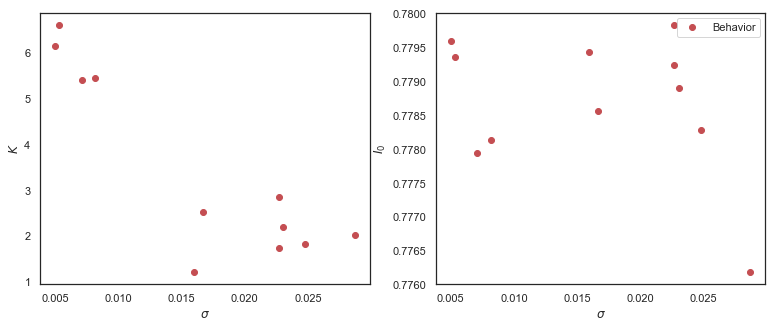

In [17]:
# Collate results
combi_arr = np.array(combi_collection)
sigmas = combi_arr[:,0]
Iarr = combi_arr[:,1]
Karr = combi_arr[:,2]

# Plot the results
plt.figure(figsize=(13,5))
plt.subplot(121)
# Simulation
#for i, sigma in enumerate(sigma_lst):
#    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
# Behavior
plt.plot(sigmas, Karr, 'or')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$K$')

plt.subplot('122')
# Simulation
#for i, sigma in enumerate(sigma_lst):
#    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
# Behavior
plt.plot(sigmas, Iarr, 'or', label='Behavior')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$I_0$')
plt.legend()

#plt.savefig('KI_relationship.pdf')

In [86]:
scipy.io.savemat('PlotTools/IK_subject_fit_020419_thres0_7_constant_stage0_750ms.mat', 
                 {'combi_arr': combi_arr, 'all_subject_files': all_subject_files})
scipy.io.savemat('PlotTools/IK_relationship_020419_constant_stage0_750ms.mat',
                {'ILST': ILST, 'KLST': KLST, 'sigma_lst': sigma_lst})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


## Plot model and subject BIAS, VAR, and RMSE

In [18]:
collated_bias_var = []

for i in range(len(all_subject_files)):
    print('Doing subject #%d of %d...' % (i + 1, len(all_subject_files)))
    # Load data for subject
    subject_file = all_subject_files[i]
    sigmaval = combi_arr[i,0]
    Ival = combi_arr[i,1]
    Kval = combi_arr[i,2]

    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

    #1,2,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst.append(np.mean(times))
        prod_var_lst.append(np.std(times))

    #1,2,3,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst2.append(np.mean(times))
        prod_var_lst2.append(np.std(times))

    # Bias
    bias_model1 = np.sum((np.array(prod_time_lst) * 10 - tss.T)**2) / len(tss)
    bias_subject1 = np.sum((target_time1 - tss.T)**2) / len(tss)
    bias_model2 = np.sum((np.array(prod_time_lst2) * 10 - tss.T)**2) / len(tss)
    bias_subject2 = np.sum((target_time2 - tss.T)**2) / len(tss)

    # Variance
    var_model1 = np.sum((np.array(prod_var_lst) * 10)**2) / len(tss)
    var_subject1 = np.sum(stdtp_in[:,0]**2) / len(tss)
    var_model2 = np.sum((np.array(prod_var_lst2) * 10)**2) / len(tss)
    var_subject2 = np.sum(stdtp_in[:,1]**2) / len(tss)
    
    # Collate
    collated_bias_var.append((bias_model1, bias_subject1, bias_model2, bias_subject2,
                             var_model1, var_subject1, var_model2, var_subject2))

collated_bias_var = np.sqrt(np.array(collated_bias_var))

Doing subject #1 of 11...
Doing subject #2 of 11...
Doing subject #3 of 11...
Doing subject #4 of 11...
Doing subject #5 of 11...
Doing subject #6 of 11...
Doing subject #7 of 11...
Doing subject #8 of 11...
Doing subject #9 of 11...
Doing subject #10 of 11...
Doing subject #11 of 11...


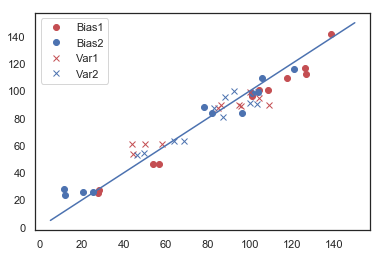

In [19]:
# Plot bias and variance
plt.plot(collated_bias_var[:,0], collated_bias_var[:,1], 'ro', label='Bias1')
plt.plot(collated_bias_var[:,2], collated_bias_var[:,3], 'bo', label='Bias2')
plt.plot(collated_bias_var[:,4], collated_bias_var[:,5], 'rx', label='Var1')
plt.plot(collated_bias_var[:,6], collated_bias_var[:,7], 'bx', label='Var2')
plt.plot([5,150], [5, 150])
plt.legend()

In [21]:
# Save collated bias and variance
suffix = '021119_thres0_7_constant_stage0_750ms_Krange1to8_Irange77to79_sigma005to04.mat'
scipy.io.savemat('PlotTools/IK_subject_fit_' + suffix, 
                 {'combi_arr': combi_arr, 'all_subject_files': all_subject_files})
#scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
#                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst})
scipy.io.savemat('PlotTools/biasvar_' + suffix, 
                 {'collated_bias_var': collated_bias_var, 'all_subject_files': all_subject_files})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


In [62]:
Iresults

[array([[0.78809019, 0.78884011, 0.78673917, 0.78835308, 0.78998716,
         0.7872017 , 0.78831219, 0.78965924, 0.78987637, 0.78751713],
        [0.77876566, 0.7780018 , 0.78034834, 0.78100918, 0.77925654,
         0.7803639 , 0.77809483, 0.77711177, 0.77947069, 0.78027868],
        [0.78002692, 0.7770923 , 0.7785422 , 0.77912482, 0.779219  ,
         0.78007803, 0.77678187, 0.77891956, 0.78097363, 0.78085924],
        [0.78174379, 0.77876805, 0.77882841, 0.77921543, 0.77939682,
         0.77878389, 0.78279536, 0.78107547, 0.78052628, 0.78093314],
        [0.77940451, 0.78033891, 0.78013772, 0.78238905, 0.77953525,
         0.78305766, 0.78372731, 0.77986596, 0.77773973, 0.78352933],
        [0.78052154, 0.78090044, 0.78038872, 0.78520526, 0.78139775,
         0.77789012, 0.77905976, 0.77982284, 0.78101287, 0.78034774]]),
 array([[0.78140293, 0.78440769, 0.7814341 , 0.78167253, 0.78306761,
         0.78194615, 0.78165691, 0.78080198, 0.78094916, 0.78092764],
        [0.77704907, 0.77

In [67]:
suffix = '020719_thres0_7_constant_stage0_750ms_optimized3_Krange1to7B.mat'

scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst,
                'nstages': np.arange(3, 14), 'PARAMS': PARAMS_DICT})
